Imports of pandas, seaborn

In [37]:
import pandas as pd
import seaborn as sns
from itertools import islice
import nltk
from nameparser.parser import HumanName
import time

Download necessary ressources

In [27]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Geoffrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Geoffrey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Geoffrey\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Geoffrey\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

Read train dataset from csv file

In [12]:
df = pd.read_csv("../data/train.csv")

Statistical analysis about length of every "text" in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

[Text(0.5, 0, '100 of characters'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Length of articles in 100 of characters')]

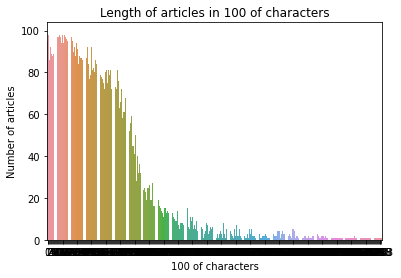

In [13]:
content_length = {}
for content in df["text"]:
    try:
        if len(content) in content_length:
            content_length[len(content)]+=1
        else:
            content_length[len(content)] = 1
    except: # Error in the dataset, one of the entries seems to be a float. To prevent execution stop: try/except.
        pass

content_length = dict(reversed(sorted(content_length.items(), key=lambda item: item[0]))) 

values = {}

for loop in content_length.items():
    if loop[0]//100 in values:
        values[loop[0]//100]+=1
    else:
        values[loop[0]//100] = 1

my_df = pd.DataFrame(values.items())
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = '100 of characters', ylabel='Number of articles', title='Length of articles in 100 of characters')


Statistical analysis about length of every fake news (label = 1) in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

[Text(0.5, 0, '100 of characters'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Length of fake news in 100 of characters')]

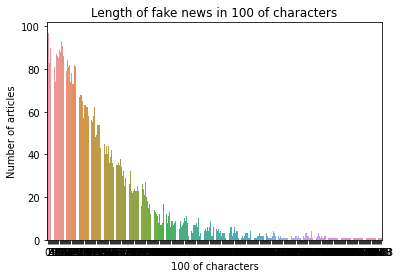

In [14]:
content_length = {}
for content in df.loc[df['label'] == 1]["text"]:
    try:
        if len(content) in content_length:
            content_length[len(content)]+=1
        else:
            content_length[len(content)] = 1
    except: # Error in the dataset, one of the entries seems to be a float. To prevent execution stop: try/except.
        pass

content_length = dict(reversed(sorted(content_length.items(), key=lambda item: item[0]))) 

values = {}

for loop in content_length.items():
    if loop[0]//100 in values:
        values[loop[0]//100]+=1
    else:
        values[loop[0]//100] = 1

my_df = pd.DataFrame(values.items())
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = '100 of characters', ylabel='Number of articles', title='Length of fake news in 100 of characters')


Statistical analysis about length of every non fake news (label = 0) in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

[Text(0.5, 0, '100 of characters'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Length of fake news in 100 of characters')]

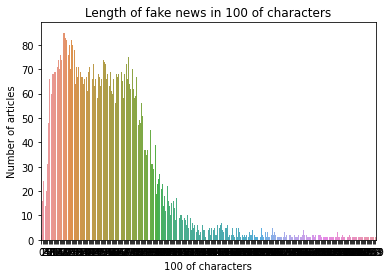

In [15]:
content_length = {}
for content in df.loc[df['label'] == 0]["text"]:
    try:
        if len(content) in content_length:
            content_length[len(content)]+=1
        else:
            content_length[len(content)] = 1
    except: # Error in the dataset, one of the entries seems to be a float. To prevent execution stop: try/except.
        pass

content_length = dict(reversed(sorted(content_length.items(), key=lambda item: item[0]))) 

values = {}

for loop in content_length.items():
    if loop[0]//100 in values:
        values[loop[0]//100]+=1
    else:
        values[loop[0]//100] = 1

my_df = pd.DataFrame(values.items())
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = '100 of characters', ylabel='Number of articles', title='Length of fake news in 100 of characters')

Check amount of names and save result to CSV file.

In [38]:
def get_human_names(text):
    tokens = nltk.tokenize.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    sentt = nltk.ne_chunk(pos, binary = False)
    person_list = []
    person = []
    name = ""
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON'):
        for leaf in subtree.leaves():
            person.append(leaf[0])
        if len(person) > 1: #avoid grabbing lone surnames
            for part in person:
                name += part + ' '
            if name[:-1] not in person_list:
                person_list.append(name[:-1])
            name = ''
        person = []

    return (person_list)

start_time = time.time()

for id, content in enumerate(df["text"]):

    if id < 100:
        try:
            print(id, len(get_human_names(content)))
        except:
            pass

print(time.time()-start_time)


0 17
1 12
2 11
3 4
4 3
5 4
6 7
7 13
8 10
9 21
10 15
11 4
12 7
13 5
14 37
15 16
16 10
17 5
18 3
19 3
20 2
21 12
22 3
23 5
24 7
25 3
26 9
27 6
28 11
29 58
30 5
31 15
32 15
33 13
34 13
35 13
36 31
37 16
38 5
39 0
40 4
41 4
42 14
43 0
44 5
45 18
46 3
47 7
48 4
49 3
50 4
51 7
52 3
53 0
54 0
55 3
56 4
57 11
58 6
59 18
60 4
61 0
62 13
63 4
64 10
65 1
66 32
67 8
68 7
69 2
70 3
71 87
72 4
73 29
74 18
75 25
76 1
77 3
78 10
79 4
80 14
81 0
82 0
83 1
84 14
85 12
86 1
87 21
88 7
89 20
90 5
91 6
92 11
93 14
94 9
95 8
96 2
97 4
98 12
99 7


TypeError: 'float' object is not callable